# **Non-Stationary Federated Learning**



*   Deep Learning Framework: **PyTorch**
*   Dataset: **Synthetic**
*   Workers: **4**
*   Data Distribution: **IID on workers**





## Importing libraries and setting parameters for training


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F


import os
import numpy as np
import math

from Stationary.core import *
from Stationary.utils import *

from sklearn import linear_model, datasets
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt

In [2]:
num_workers = 6
num_rounds = 10

## Synthetic Dataset

We create a synthetic dataset, reproducing a linear correlation between inputs and outputs, with the addition of a noise.

Train set is divided into multiple slots, in order to reproduce the "online" approach: For each round, each worker has a different set for training phase.


In [3]:
# Linear Regression Coefficients
m = 1.4
c = 10

dataset_X = np.linspace(0, 10, 1000)
np.random.shuffle(dataset_X)

dataset_y =  dataset_X * m + c +  np.random.randn(dataset_X.size) * math.sqrt(3)

dataset_X = dataset_X.reshape(-1,1)
dataset_y = dataset_y.reshape(-1,1)

In [4]:
train_percentage = 0.9


train_X, test_X = np.split(dataset_X, 
            [int(train_percentage * len(dataset_X))
            ])

train_y, test_y = np.split(dataset_y, 
            [int(train_percentage * len(dataset_y))
            ])

In [5]:
train_list_X = splitDataset(train_X, num_workers, num_rounds)
train_list_y = splitDataset(train_y, num_workers, num_rounds)

In [6]:
worker_list = []
for i in range(0, num_workers):
    worker_list.append(Worker(coef = np.zeros(shape=dataset_X[0].size), intercept = np.zeros(shape=1), model=linear_model.LinearRegression()))

In [7]:
server = Server(coef = np.zeros(shape=dataset_X[0].size), intercept = np.zeros(shape=1), workers = worker_list, num_features = dataset_X[0].size)

In [8]:
error = []
score = []

for i in range(0, num_rounds):
    
    for j in range(0, num_workers):
        worker_list[j].train(X = train_list_X[i*num_workers+j] , y = train_list_y[i*num_workers+j])

    server.aggregation() 
    server.return_to_workers()
    
    pred_server = server.evaluate(test_X)
    print('------ROUND {}------'.format(i+1))
    print('Mean squared error: %.3f' 
          % mean_squared_error(test_y, pred_server))
    print('Coefficient of determinaton: %.3f \n'
          % r2_score(test_y, pred_server))
    error.append(mean_squared_error(test_y, pred_server))
    score.append(r2_score(test_y, pred_server))

------ROUND 1------
Mean squared error: 2.515
Coefficient of determinaton: 0.852 

------ROUND 2------
Mean squared error: 2.536
Coefficient of determinaton: 0.850 

------ROUND 3------
Mean squared error: 2.507
Coefficient of determinaton: 0.852 

------ROUND 4------
Mean squared error: 2.501
Coefficient of determinaton: 0.853 

------ROUND 5------
Mean squared error: 2.499
Coefficient of determinaton: 0.853 

------ROUND 6------
Mean squared error: 2.496
Coefficient of determinaton: 0.853 

------ROUND 7------
Mean squared error: 2.496
Coefficient of determinaton: 0.853 

------ROUND 8------
Mean squared error: 2.498
Coefficient of determinaton: 0.853 

------ROUND 9------
Mean squared error: 2.502
Coefficient of determinaton: 0.853 

------ROUND 10------
Mean squared error: 2.513
Coefficient of determinaton: 0.852 



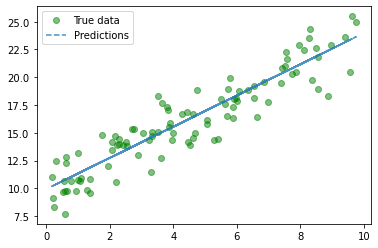

In [9]:
plt.clf()
plt.plot(test_X, test_y, 'go', label='True data', alpha=0.5)
plt.plot(test_X, pred_server, '--', label='Predictions', alpha=0.8)
plt.legend(loc='best')
plt.show()

# Federated Averaging

Implementation of FedAVG in PyTorch. 

First of all, the dataset is converted in tensors.
Then, a model, a loss function and an optimizer are instantiated for each worker.
Model parameters are averaged at each round.

In [10]:
from torch.autograd import Variable

for i in range(0, len(train_list_X)):
    train_list_X[i] = torch.from_numpy(train_list_X[i])

for i in range(0, len(train_list_y)):
    train_list_y[i] = torch.from_numpy(train_list_y[i])

## Model


In [11]:
class linearRegression(torch.nn.Module):
    
    def __init__(self, inputSize, outputSize):
        
        super(linearRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize, bias=True)

        
    def forward(self, x):
        
        out = self.linear(x)
        return out


In [12]:
w = []

for i in range(0, num_workers):
    
    w.append(linearRegression(dataset_X[0].size, dataset_y[0].size))
    w[i] = w[i].float()

In [13]:
learning_rate = 1e-4

criterion = []
optimizers = []

for i in w:
    
    criterion.append(torch.nn.MSELoss()) 
    optimizers.append(torch.optim.SGD(i.parameters(), lr=learning_rate))

In [14]:
params = []


for i in w:
    params.append(list(i.parameters()))

In [15]:
from collections import defaultdict

local_epochs = 100

error = []
score = []


for model in w:
    model.train()
    

# stores losses trend for each worker along epochs
worker_losses_dict = defaultdict(list)


for i in range(num_rounds):
    
    print("\n## ## ## ROUND {} ## ## ##\n".format(i))
    
    for j in range(0, num_workers):
        
        print("# # # WORKER {} # # #\n".format(j))
        
        for p in w[j].parameters():
            print(p.data)

        for epoch in range(local_epochs):
            
            optimizers[j].zero_grad()
            loss = 0
            
            for x in range(len(train_list_X[i*num_workers+j])):
                inputs = (train_list_X[i*num_workers+j][x]).float()
                inputs = inputs.unsqueeze(0)
                labels = (train_list_y[i*num_workers+j][x]).float()
                labels = labels.unsqueeze(0)
                y_pred = w[j](inputs)
                loss += criterion[j](y_pred, labels)
            
            # store loss info for current epoch 
            worker_losses_dict[j].append(loss)
            
            loss.backward()
            optimizers[j].step()
        
        print("loss:\t{}".format(loss))    
        
        predicted = w[j](Variable(torch.from_numpy(test_X).float())).data.numpy()
        
        print('Mean squared error: %.3f\n' 
              % mean_squared_error(test_y, predicted))
        print('Coefficient of determinaton: %.3f \n\n'
              % r2_score(test_y, predicted))
        error.append(mean_squared_error(test_y, predicted))
        score.append(r2_score(test_y, predicted))
        
    
    new_params = list()

    for param_i in range(len(params[0])):

        spdz_params = list()

        for remote_index in range(len(w)):
            spdz_params.append(params[remote_index][param_i])
        
        spdz = torch.tensor([0.0]).float()

        for k in spdz_params:
            spdz = spdz + k
        
        new_param = (spdz) / len(w)
        new_params.append(new_param)
    
    with torch.no_grad():
        for model in params:
            for param in model:
                param *= 0
        
        for remote_index in range(len(w)):
            for param_index in range(len(params[remote_index])):
                params[remote_index][param_index].set_(new_params[param_index])
    
    
    predicted = w[0](Variable(torch.from_numpy(test_X).float())).data.numpy()
    
    print('------ROUND {}------'.format(i))
    print('Mean squared error: %.3f' 
          % mean_squared_error(test_y, predicted))
    print('Coefficient of determinaton: %.3f \n'
          % r2_score(test_y, predicted))
    error.append(mean_squared_error(test_y, predicted))
    score.append(r2_score(test_y, predicted))
    


## ## ## ROUND 0 ## ## ##

# # # WORKER 0 # # #

tensor([[0.5211]])
tensor([-0.2744])
loss:	340.2954406738281
Mean squared error: 28.873

Coefficient of determinaton: -0.702 


# # # WORKER 1 # # #

tensor([[0.2678]])
tensor([0.9860])
loss:	253.77914428710938
Mean squared error: 20.319

Coefficient of determinaton: -0.198 


# # # WORKER 2 # # #

tensor([[0.3324]])
tensor([0.4207])
loss:	291.1007385253906
Mean squared error: 23.783

Coefficient of determinaton: -0.402 


# # # WORKER 3 # # #

tensor([[0.7434]])
tensor([0.3720])
loss:	167.29336547851562
Mean squared error: 23.682

Coefficient of determinaton: -0.396 


# # # WORKER 4 # # #

tensor([[0.2893]])
tensor([-0.5332])
loss:	455.4219970703125
Mean squared error: 26.079

Coefficient of determinaton: -0.537 


# # # WORKER 5 # # #

tensor([[-0.1494]])
tensor([0.6819])
loss:	446.5617370605469
Mean squared error: 21.445

Coefficient of determinaton: -0.264 


------ROUND 0------
Mean squared error: 23.657
Coefficient of determinato

loss:	46.447608947753906
Mean squared error: 2.507

Coefficient of determinaton: 0.852 


# # # WORKER 3 # # #

tensor([[1.4193]])
tensor([9.6628])
loss:	40.9870491027832
Mean squared error: 2.509

Coefficient of determinaton: 0.852 


# # # WORKER 4 # # #

tensor([[1.4282]])
tensor([9.6415])
loss:	60.23744201660156
Mean squared error: 2.560

Coefficient of determinaton: 0.849 


# # # WORKER 5 # # #

tensor([[1.3772]])
tensor([9.6757])
loss:	47.0122184753418
Mean squared error: 2.532

Coefficient of determinaton: 0.851 


------ROUND 8------
Mean squared error: 2.532
Coefficient of determinaton: 0.851 


## ## ## ROUND 9 ## ## ##

# # # WORKER 0 # # #

tensor([[1.4533]])
tensor([9.6814])
loss:	23.563539505004883
Mean squared error: 2.756

Coefficient of determinaton: 0.838 


# # # WORKER 1 # # #

tensor([[1.5019]])
tensor([9.7881])
loss:	42.020503997802734
Mean squared error: 2.527

Coefficient of determinaton: 0.851 


# # # WORKER 2 # # #

tensor([[1.3782]])
tensor([9.7487])
loss:	

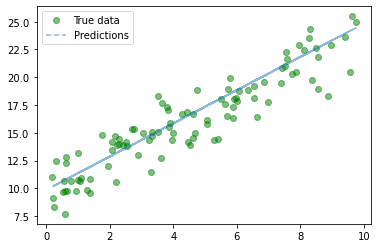

In [16]:
with torch.no_grad(): 
    predicted = w[0](Variable(torch.from_numpy(test_X).float())).data.numpy()

plt.clf()
plt.plot(test_X, test_y, 'go', label='True data', alpha=0.5)
plt.plot(test_X, predicted, '--', label='Predictions', alpha=0.5)
plt.legend(loc='best')
plt.show()

In [17]:
print(mean_squared_error(test_y, pred_server))
print(r2_score(test_y, pred_server))

2.5127396819641317
0.8518888208719344


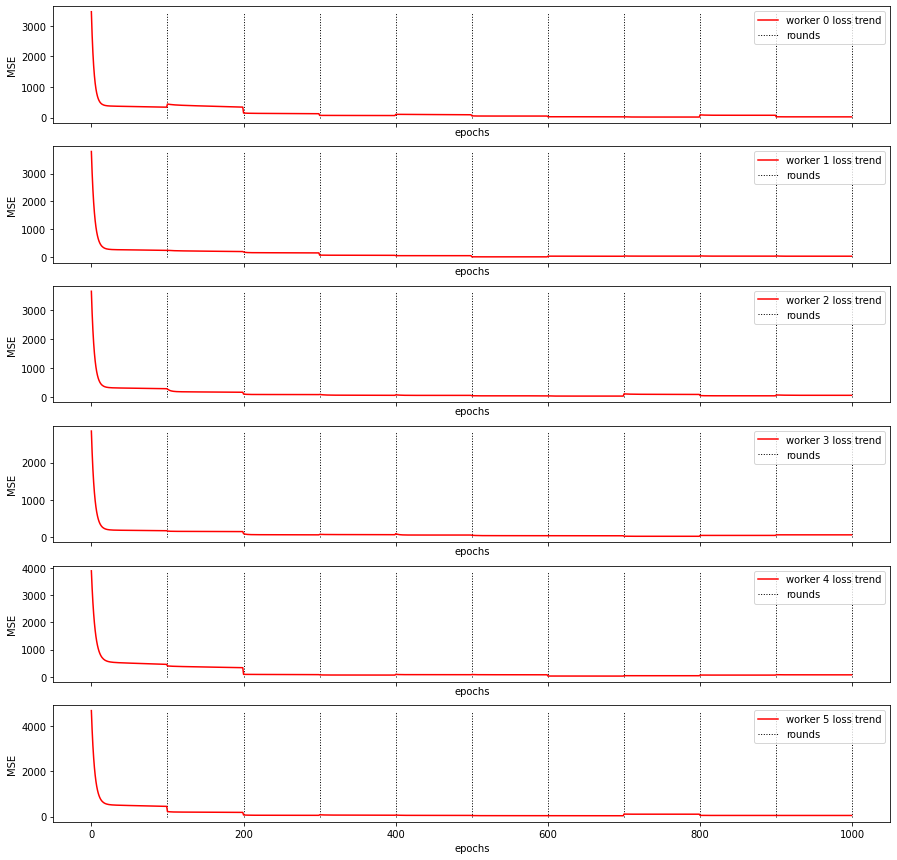

In [18]:
# plot loss over epochs for each worker

fig, axs = plt.subplots(num_workers, 1, sharex=True, figsize=(15, 15))
for k, v in worker_losses_dict.items():
    axs[k].plot(v, label = "worker {} loss trend".format(k), color = 'red')
    axs[k].set_xlabel("epochs")
    axs[k].set_ylabel("MSE")
    
    axs[k].vlines((np.arange(num_rounds+1)*local_epochs)[1:], ymin = 0, ymax = np.max(v), linewidth=1, linestyle=':', label = 'rounds')
    
    axs[k].legend()


plt.savefig("loss_trend.pdf", bbox_inches='tight')